In [1]:
import datasets as ds
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import itertools
import os
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

2022-03-07 02:18:40.465893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-07 02:18:40.467738: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-07 02:18:40.467977: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (42b10f96906e): /proc/driver/nvidia/version does not exist
2022-03-07 02:18:40.471188: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


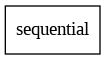

In [3]:
model = tf.keras.Sequential([
    
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
plot_model(model)

In [2]:
CUR_DIR = os.path.abspath(os.curdir)
ROOT_DIR = os.path.dirname(CUR_DIR)
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
DATA_DIR = os.path.join(ROOT_DIR, "data")
DATA_DIR

'/home/jovyan/projects/vector-nlp/data'

In [3]:
#ds.list_datasets()

In [3]:
app_dataset = ds.load_dataset('app_reviews',split='train')
app_df = app_dataset.to_pandas()
app_df['review_ls'] = app_df['review'].apply(lambda x: x.split(" "))
vocabulary = list(itertools.chain(*app_df['review_ls']))

Using custom data configuration default
Reusing dataset app_reviews (/home/jovyan/.cache/huggingface/datasets/app_reviews/default/0.0.0/20335b51b604b9bc04b7be253cd8445caa9ba93f15f39a4b0492b9e9102853de)


In [5]:
# X = app_df['review_lemma']
X = app_df['review']
y = app_df['star']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
# X_train = vect.fit_transform(X_train)
# X_test = vect.transform(X_test)
# X_val = vect.transform(X_val)

In [8]:
# from collections import Counter
# results = Counter(app_df.review_clean)
VOCAB_SIZE = len(vocabulary)
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

2022-03-07 00:17:11.186438: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [11]:
np.array(encoder.get_vocabulary())

array(['', '[UNK]', 'the', ..., '00006', '00002323', '0000000000000'],
      dtype='<U474')

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [16]:
model.compile(loss = tf.keras.losses.mae, #mae stands for mean absolute error
              optimizer = tf.keras.optimizers.SGD(), #stochastic GD
              metrics = ['mae'])

In [17]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
5402/5402 [==============================] - 394s 72ms/step - loss: 1.4993 - mae: 1.4993 - val_loss: 1.0066 - val_mae: 1.0066
Epoch 2/10
5402/5402 [==============================] - 402s 74ms/step - loss: 0.9815 - mae: 0.9815 - val_loss: 0.9479 - val_mae: 0.9479
Epoch 3/10
5402/5402 [==============================] - 398s 74ms/step - loss: 0.9236 - mae: 0.9236 - val_loss: 0.8673 - val_mae: 0.8673
Epoch 4/10
5402/5402 [==============================] - 391s 72ms/step - loss: 0.8109 - mae: 0.8109 - val_loss: 0.7581 - val_mae: 0.7581
Epoch 5/10
5402/5402 [==============================] - 385s 71ms/step - loss: 0.7316 - mae: 0.7316 - val_loss: 0.7511 - val_mae: 0.7511
Epoch 6/10
5402/5402 [==============================] - 422s 78ms/step - loss: 0.6818 - mae: 0.6818 - val_loss: 0.6615 - val_mae: 0.6615
Epoch 7/10
5402/5402 [==============================] - 424s 78ms/step - loss: 0.6732 - mae: 0.6732 - val_loss: 0.7034 - val_mae: 0.7034
Epoch 8/10
5402/5402 [===================

In [18]:
model.evaluate(X_val, y_val)  

1801/1801 [==============================] - 44s 24ms/step - loss: 0.6730 - mae: 0.6730


[0.6729981899261475, 0.6729981899261475]

In [20]:
y_pred = model.predict(X_val)

In [21]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_val, y_pred)

0.6729983

In [23]:
from sklearn.metrics import mean_squared_error
import math
print(mean_squared_error(y_val, y_pred))
print(math.sqrt(mean_squared_error(y_val, y_pred)))

1.4270874
1.194607645290121


In [24]:
max(y_pred)

array([5.0449634], dtype=float32)

In [25]:
min(y_pred)

array([-0.369689], dtype=float32)

In [33]:
plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
